# Research Notebook
## Dana Luke Gheshlaghi
## Date: March 10th, 2025

# 1: Experience
- Coded the second half of the interactions between dark matter, the upscattering
- Spent time cross-checking my code involving the decay and upscattering interactions with my partner Romina and with Professor Tulin
- Both Simulation and Quantum team had a joint meeting to share our findings


## Motivation:

At the start of the Winter term, Professor Tulin had us split up into two teams: a Quantum team, whose primary goal was to solve the Schrödinger equation to retrieve a value for the inelastic cross-section, as well as the Simulation team, which is my team. Our goal is to code up the decay and upscattering interactions of the dark matter so that we can study its behavior in a simulation. For this to work, we would need the inelastic cross-section. Now that we are nearing the end of the research, the plan is to combine our findings so that we can produce an accurate simulation of how dark matter interacts in our model. This model states that the dark matter goes through a two-step process of upscattering, then decaying back into its ground state, releasing a light force carrier: $\chi_2 \to \chi_1 \phi$. $\chi_2$ is the dark matter in its excited state, $\chi_1$ is the ground state, and $\phi$ is the light force carrier.

# 2: What? (What happened?)
I have coded up the derivations to the derivatives of the mass and energy upscattering equations, made by Professor Tulin. These were derived from the Navier-Stokes equations for a conducting fluid which are [3]:

1.) $ D_t\rho = -\rho \vec{\nabla}\cdot\vec{v} $

2.) $ D_t\vec{v} = -\vec{\nabla}\Phi - \frac{1}{\rho}\vec{\nabla} $ 

3.) $ D_t\vec{v} = -\frac{P}{\rho} \vec{\nabla}\cdot\vec{v} $

The following are the upscattering equations I coded onto python [3]: 

$$
\left( \frac{dm_i}{dt} \right)_{\textrm{up-scat}} = 
- \frac{4 \rho_i m_i \nu_i}{\sqrt{\pi}} \frac{\langle \sigma_{\rm in}^{(3)}\rangle_i}{m} \, e^{- \nu_{loss}^2/\nu_i^2} \left(1 + \frac{\nu_{loss}^2}{\nu_i^2} \right)
$$ (1)

$$
\left( \frac{de_i}{dt}\right)_{\textrm{up-scat}} = - \frac{ \rho_i \nu_i^3}{\sqrt{\pi}} \, e^{- \nu_{loss}^2/\nu_i^2} \left[ 2 \frac{\langle \sigma_{\rm in}^{(5)}\rangle_i}{m} \left(2 + 2\frac{\nu_{loss}^2}{\nu_i^2} + \frac{\nu_{loss}^4}{\nu_i^4} \right)
- 3 \frac{\langle \sigma_{\rm in}^{(3)}\rangle_i}{m} \left(1 + \frac{\nu_{loss}^2}{\nu_i^2} \right)\, \right] 
$$

$$
\left(\frac{dm^*_i}{dt} \right)_{\textrm{up-scat}} = \sum_j T^*_{ij} \frac{4 m_j \rho_j \nu_j}{\sqrt{\pi}} \frac{\langle \sigma_{\rm in}^{(3)}\rangle_j}{m} \, e^{- \nu_{loss}^2/\nu_j^2} \left(1 + \frac{\nu_{loss}^2}{\nu_j^2} \right)
$$

$$
\left( \frac{de_i^*}{dt} \right)_{\textrm{up-scat}} 
= \sum_j T^*_{ij} \frac{ \rho_j^2 \nu_j}{\sqrt{\pi} \rho_i^*} \, e^{- \nu_{loss}^2/\nu_j^2} \left[ 2 \frac{\langle \sigma_{\rm in}^{(5)}\rangle_j}{m} \nu_j^2 \left(2 + 2\frac{\nu_{loss}^2}{\nu_j^2} + \frac{\nu_{loss}^4}{\nu_j^4} \right) \right.
$$

$$
\quad + \left. \frac{\langle \sigma_{\rm in}^{(3)}\rangle_j}{m} \left(3 \nu_j^2 + 2 (v_j - v_i^*)^2 - \frac{1}{2} \nu_{loss}^2 - 6 {\nu_i^*}^2 \right) 
\left( 1 + \frac{\nu_{loss}^2}{\nu_j^2} \right) \right]
$$

Below is essentially the bulk of what I have been working on, it includes the upscattering interactions for the ground state and excited state dark matter. 
```
def ground_state_upscattering(ground_state_shells, excited_state_shells, sigma_in_over_m, nu_loss):
    e1, v1, r1, m1, h1, rho1, W1 = (ground_state_shells.e, ground_state_shells.v, ground_state_shells.r,
                                    ground_state_shells.m, ground_state_shells.h, ground_state_shells.density,
                                    ground_state_shells.kernels.W)
    e2, v2, r2, m2, h2, rho2, W2 = (excited_state_shells.e, excited_state_shells.v, excited_state_shells.r,
                                    excited_state_shells.m, excited_state_shells.h, excited_state_shells.density,
                                    excited_state_shells.kernels.W)
    nu_disp2 = np.sqrt(2 / 3 * e2)
    sigma_m = sigma_in_over_m = 1
    nu_loss = 1.0
    num = ground_state_shells.num

    W = np.array([[W1(r1[i], r2[j], h1[i]) for j in range(num)] for i in range(num)])
    rho_i = np.sum(m1 * W, axis=1)

    dm_dt = np.array([(-4 * rho_i[i] * m2[i] * nu_disp2[i]) / (np.sqrt(np.pi)) * sigma_m * np.exp(
        -nu_loss ** 2 / nu_disp2[i] ** 2 * (1 + nu_loss ** 2 / nu_disp2[i] ** 2)) for i in range(num)])

    de_dt = np.array([(-rho_i[i] * nu_disp2[i] ** 3) / (np.sqrt(np.pi)) * np.exp(-nu_loss ** 2 / nu_disp2[i] ** 2) *
                      (2 * sigma_m * (2 + 2 * nu_loss ** 2 / nu_disp2[i] ** 2 + nu_loss ** 4 / nu_disp2[i] ** 4) -
                       3 * sigma_m * (1 + nu_loss ** 2 / nu_disp2[i] ** 2))
                      for i in range(num)])

    return dm_dt, de_dt
```

```
def excited_state_upscattering(ground_state_shells, excited_state_shells, sigma_in_over_m, nu_loss):

    e1, v1, r1, m1, h1, rho1, W1 = (ground_state_shells.e, ground_state_shells.v, ground_state_shells.r,
                                    ground_state_shells.m, ground_state_shells.h, ground_state_shells.density, ground_state_shells.kernels.W)
    e2, v2, r2, m2, h2, rho2, W2 = (excited_state_shells.e, excited_state_shells.v, excited_state_shells.r,
                                    excited_state_shells.m, excited_state_shells.h, excited_state_shells.density, excited_state_shells.kernels.W)
    nu_disp1 = np.sqrt(2 / 3 * e1)
    nu_disp2 = np.sqrt(2 / 3 * e2)
    sigma_m = sigma_in_over_m = 1
    nu_loss = 1.0
    num = ground_state_shells.num
    '''Wij2 = np.array([[W1(r2[i], r1[j], h2[j]) for j in range(num)] for i in range(num)])
    den = np.sum(np.array([[W1(r2[k], r1[j], h2[k]) for j in range(num)] for k in range(num)]), axis=0)
    Tij = np.array([[((Wij2[i][j]) / den[j]) for j in range(num)] for i in range(num)])'''
    Wij2 = np.array([[W1(r2[i], r1[j], h2[i]) for j in range(num)] for i in range(num)])
    den = np.sum(Wij2, axis=0)
    Tij = np.array([[((Wij2[i][j]) / den[j]) for j in range(num)] for i in range(num)])

    dm_dt = np.sum(np.array([[Tij[i][j] * 4 * m1[j] * rho1[j] * nu_disp1[j] * 1 / np.sqrt(np.pi) * sigma_m * np.exp(-nu_loss ** 2 / nu_disp1[j] **2) * (1 + nu_loss/nu_disp1[j]) for j in range(num)] for i in range(num)]), axis=1)

    de_dt = np.sum(np.array([[Tij[i][j] * ((rho1[j] ** 2 * nu_disp1[j]) / (np.sqrt(np.pi) * rho2[i]) * np.exp(-nu_loss ** 2 / nu_disp1[j] ** 2)) *(2 * sigma_m * nu_disp1[j] * (2 + 2 * nu_loss ** 2 / nu_disp1[j] + nu_loss ** 4 / nu_disp1[j] ** 4) + sigma_m * (3 * nu_disp1[j] ** 2 + 2 *(nu_disp1[j] - nu_disp1[j]) ** 2-0.5 * nu_loss ** 2 - 6 * nu_disp2[i] ** 2) * (1 + nu_loss ** 2 / nu_disp1[j] ** 2)) for j in range(num)] for i in range(num)]), axis=1)

    return dm_dt, de_dt
```

The code runs but unfortunatley the values are not what was expected, comparing with Romina and Professor Tulin it seems that none of us had matching values. Fortunatley, a meeting we happened last week was dedicated for Romina and I to debug our decay code and have everything match. We multipied our derivatives by kpc_per_cm_sq_times_g_per_Msol to fix the units. 


# 3: So what? (What does it mean?)

Similar images were shown in the last journal, but now that the derivatives have been debugged and produce the intended values, I have plotted the graphs of the dark matter's behavior over a time interval of 0.1 gigayears with 100 shells spanning 100 points in that time. Using SPH (Smoothed Particle Hydrodynamics) means we are treating the dark matter as a fluid, since point particles tend to give us less accurate results. As a fluid, this leaves less error when solving within a certain radius. This is achieved by the smoothing kernel in the SPH code. By smearing the particles into a certain radius, less data is lost when taking these shells/radii as the boundary being studied. 0.1 gigayears is relatively short; unfortunately, any longer would take hours for my computer to process, but the data produced is still sufficient.

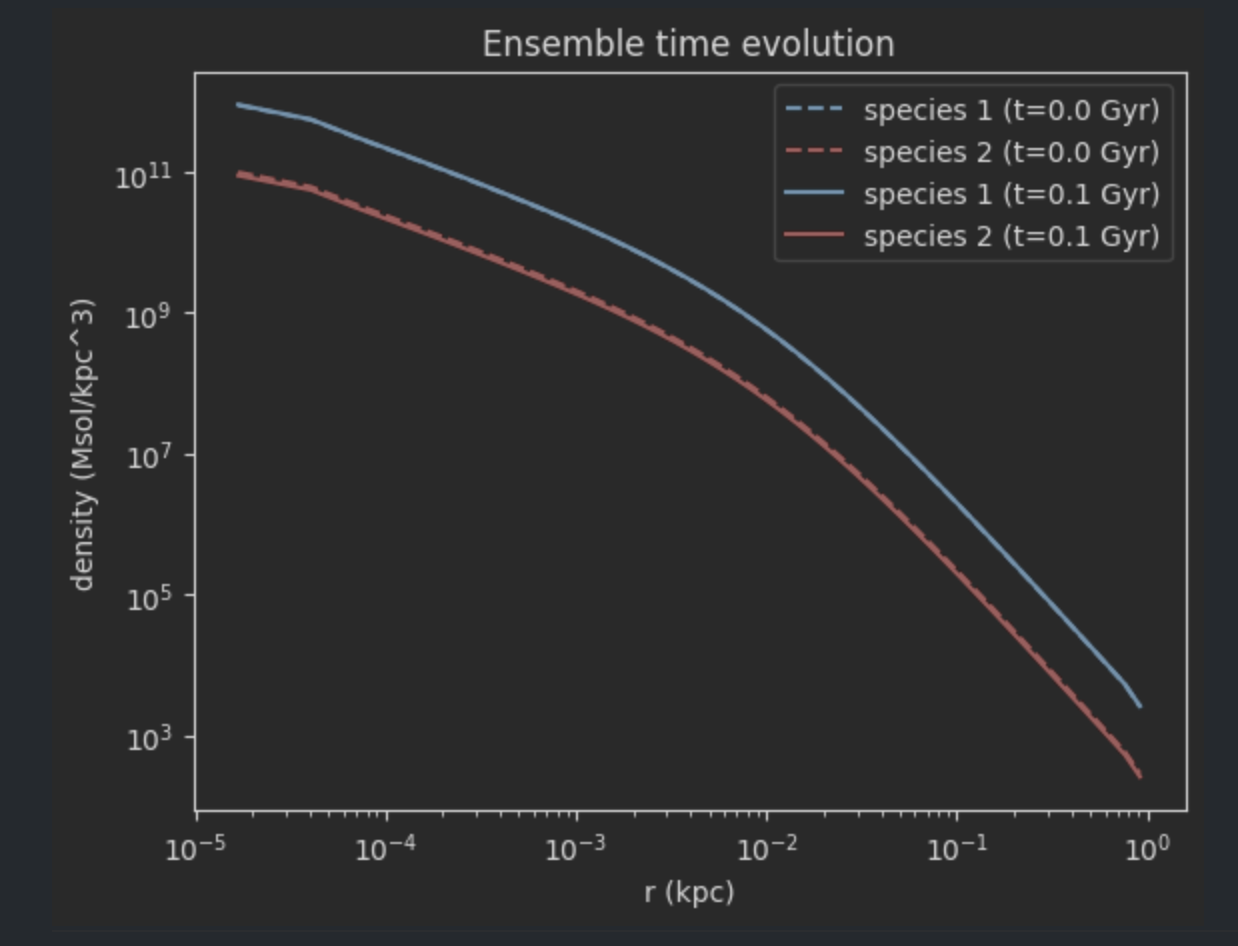
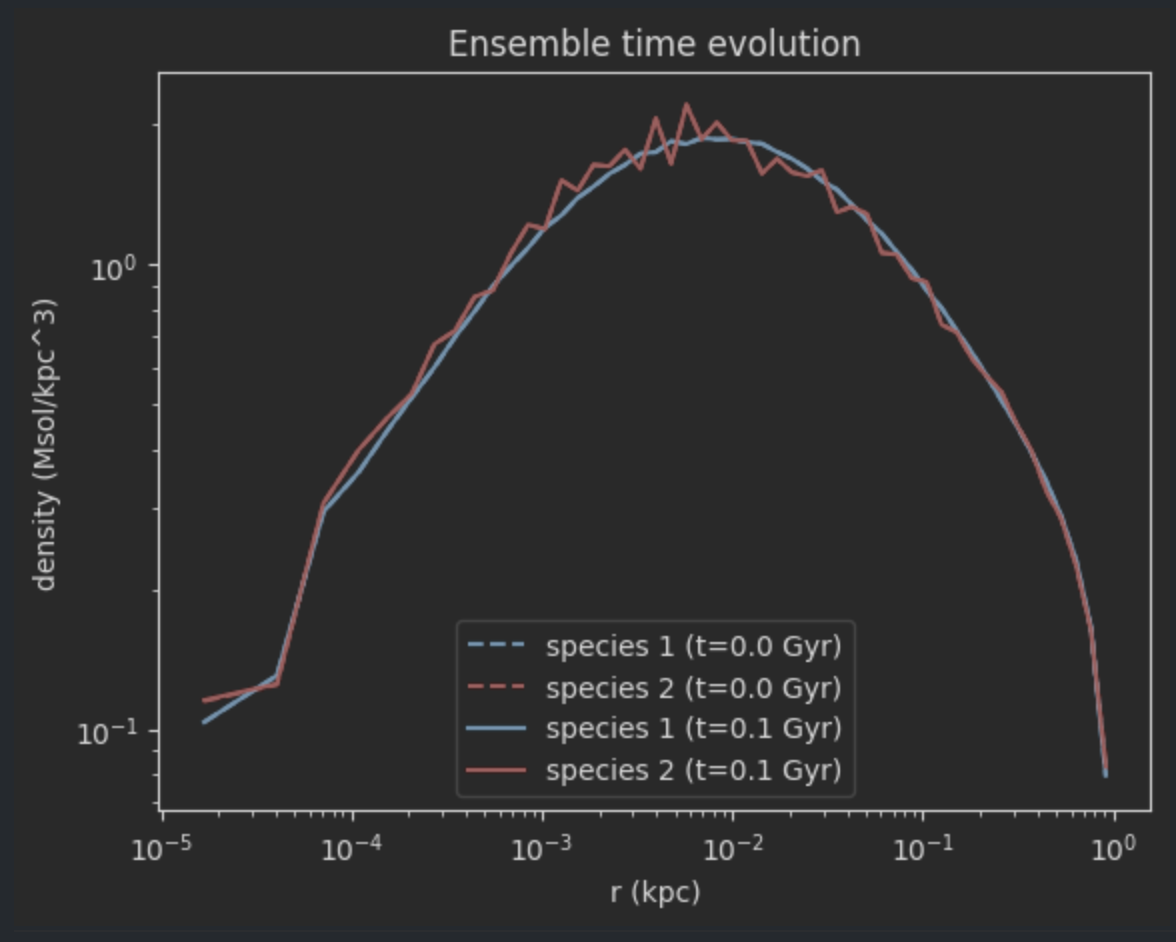
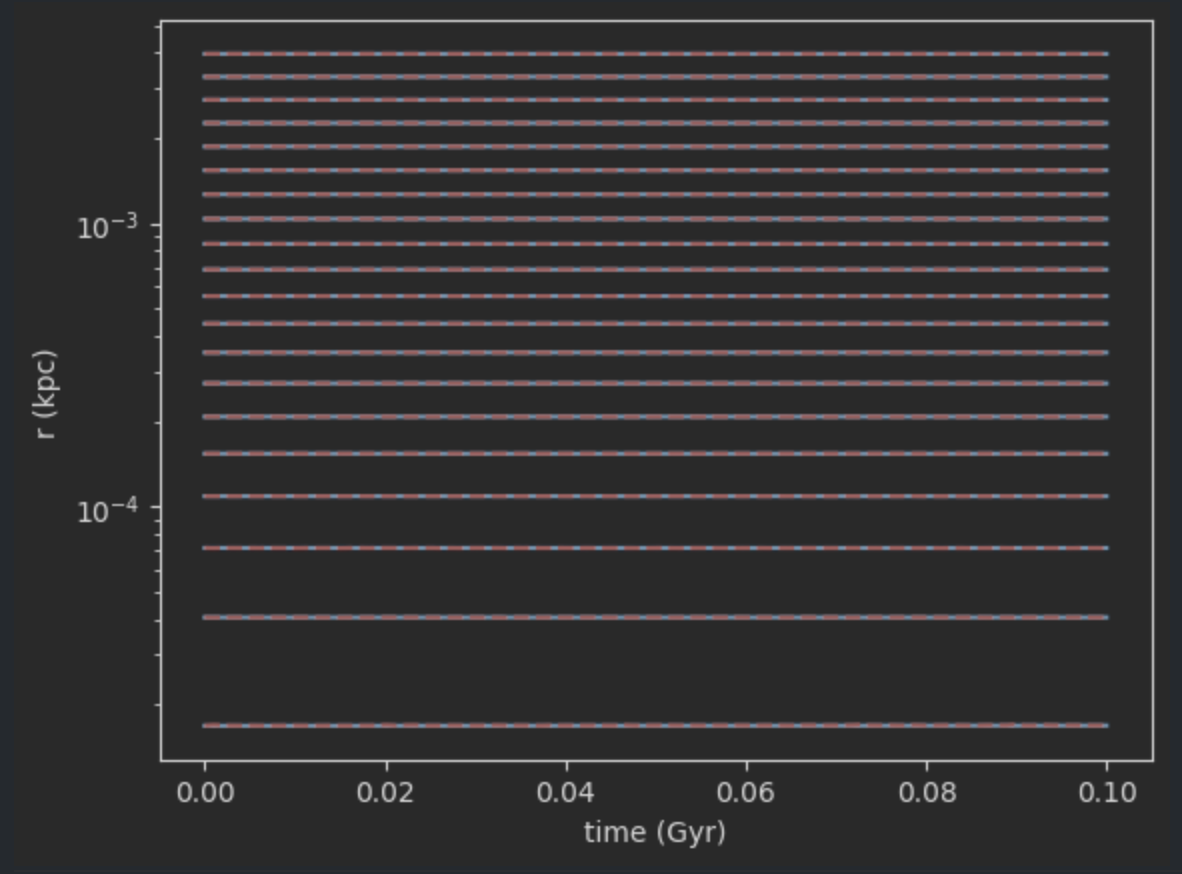
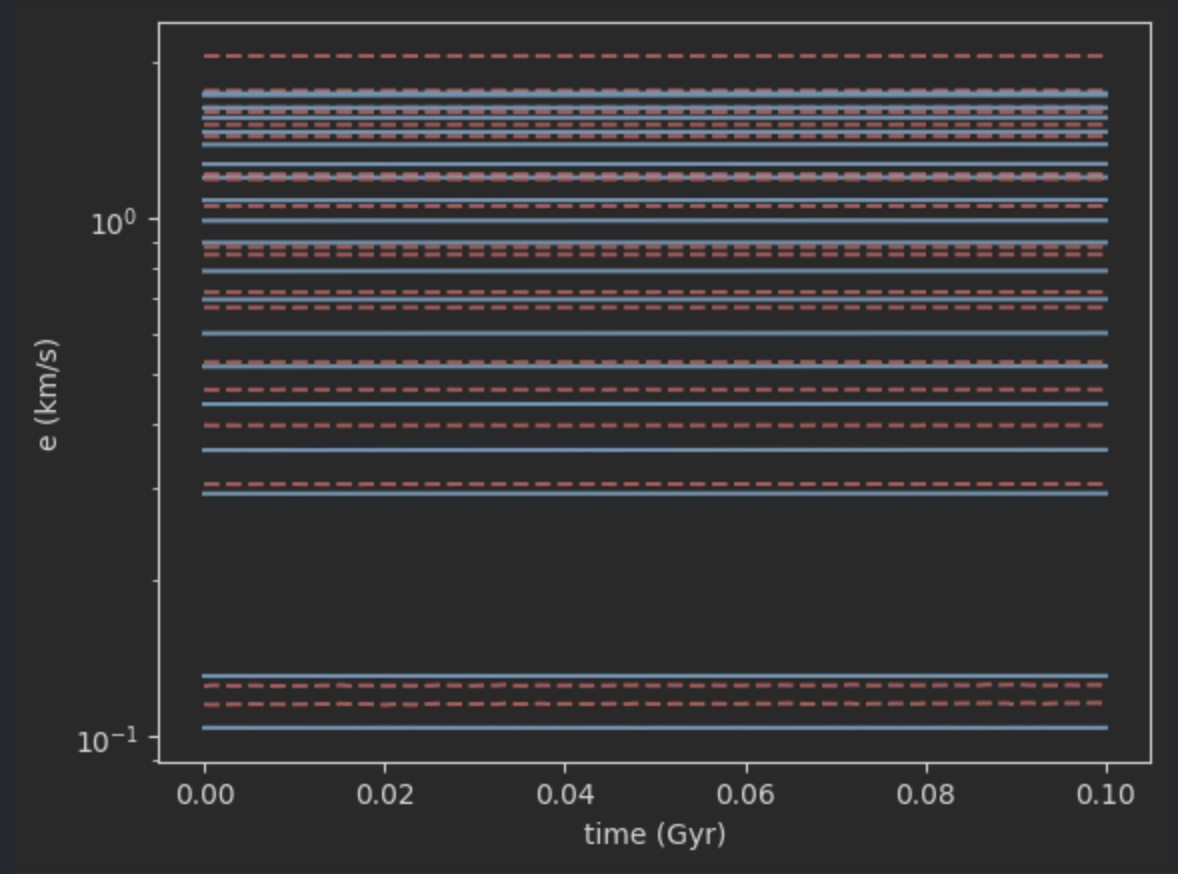
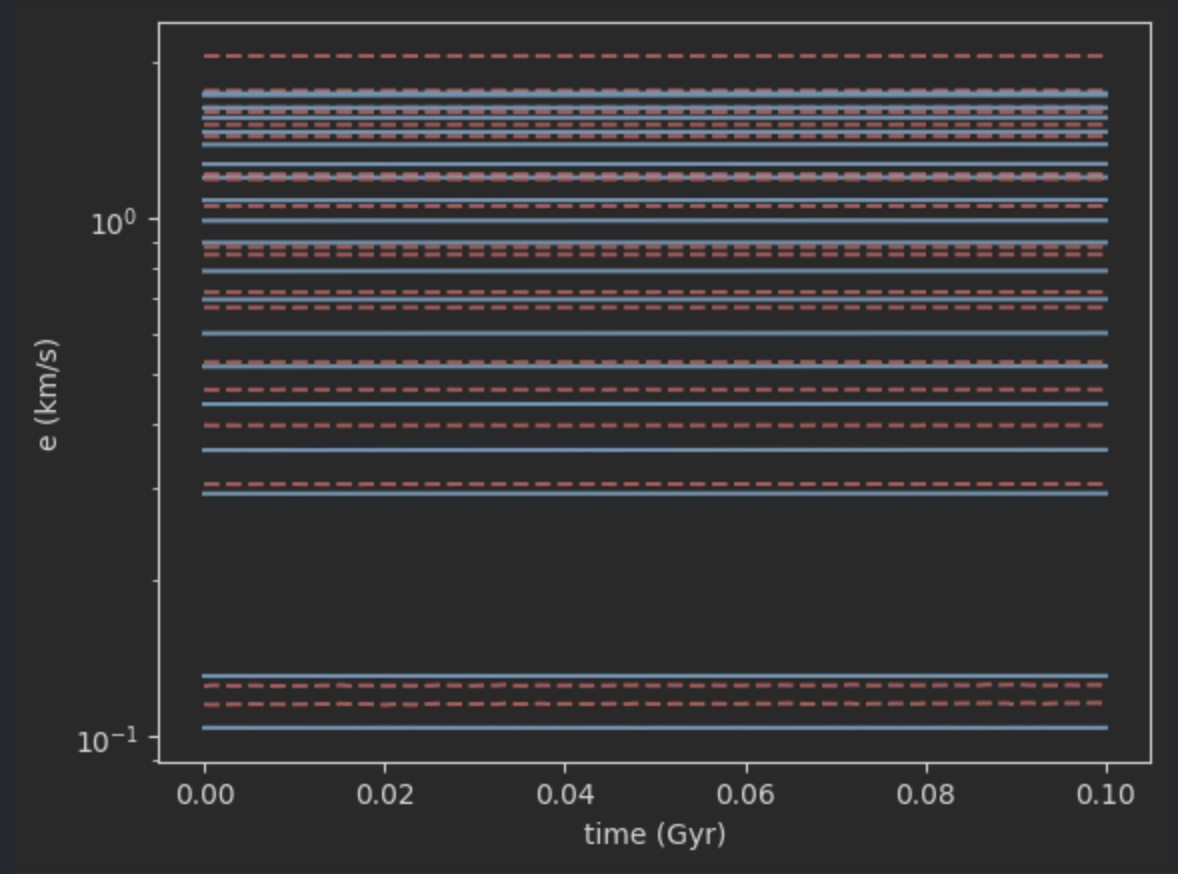

The first image is a plot of density vs. time. What we see is that the image resembles the Navarro-Frenk-White (NFW) profile.

A little background on the NFW profile: The Small-Scale Structure Problem refers to discrepancies in the Cold Dark Matter (CDM) model, such as the NFW profile, which predicts that dark matter density increases very steeply at the center of galaxies, specifically targeting smaller bodies like dwarf galaxies and low-surface-brightness galaxies. The Core-Cusp Problem branches from the Small-Scale Structure Problem as it addresses one of these discrepancies—observations of mass distribution in smaller galaxies suggest that the central dark matter density is relatively flat, forming a core rather than a cusp.

The second image is a plot of density vs. radius, followed by plots of radius vs. time, internal energy over time, and mass over time. Without a longer time interval, a significant difference cannot be seen. However, this data is important to our work as it provides insight into how dissipative dark matter interacts with itself, its properties, and any details that may otherwise be overlooked.

The intention of the upscattering interaction is to complete the interactions code for SPHerical. This will aid us in further simulations involving both decay and upscattering interactions as both will be occuring.

# 4. Now what? (What's next?)
## Plan for the next week
- Right now, although my upscattering code is working, it does not match Romina’s and Professor Tulin’s results. The intention of all of us working independently first is, of course, to learn how to code this and gain experience. But by first working independently, we can really get to know how our code works—every detail—coming up with our own ways to make the code function properly and efficiently. We compare to ensure we are all on the same page. If two or one of us disagrees on something, we explain what we have done, make comparisons to the derivations from [3], and debug until all our values match and we are satisfied with the results. So, the first thing I need to do is fix my upscattering code.

- Next is to combine the upscattering and decay code into one .py file, just for convenience. They are derived from the Navier-Stokes equations, so there are many similarities. Organization in such a big package is crucial to getting work done.

- The last code before we start the simulation is for the elastic scattering of dark matter.

- Last week, the Quantum team and the Simulation team only caught each other up on what their groups have been doing. The big-picture idea is for the Quantum team to send over their work on solving the Schrödinger equation to get the cross-section value. Then, we, the Simulation team, can input that into a simulation and produce results for the dissipative dark matter model. At the moment, we have been using a filler value of '1' just to have our code ready.

# 5. Bibliography

[1] S. Tulin *Lecture 1, Lecture 2* https://drive.google.com/drive/folders/1EkPePcG7itxzHtS42bgpMsvcAANswK78

[2] S. Tulin, R. Blaff, Y. Han, H. Vormann *Smoothed Shell Hydrodynamics Simulations for Interacting Dark Matter Halos Draft* https://drive.google.com/drive/folders/1EkPePcG7itxzHtS42bgpMsvcAANswK78

[3] S. Tulin *Dissipative dark matter interactions* (Privated document on Overleaf)

[4] S. Tulin *Dissipative-Dark-Halos* https://github.com/dark-physics/dissipative-dark-halos